## Install required packages

In [1]:
%%capture
import os

packages_installed_flag = ".pip_packages_installed"

if not os.path.exists(packages_installed_flag):
    # install torch with cuda 12.8 from Aliyun mirror
    # Note: You can change the index URL if needed.
    %pip install torch==2.7.0+cu128 torchaudio==2.7.0+cu128 -f https://mirrors.aliyun.com/pytorch-wheels/cu128
    %pip install transformers datasets einops sentencepiece omegaconf numpy soundfile librosa
    # for notebook
    %pip install tqdm pandas matplotlib scikit-learn
    # for download dataset and model
    %pip install huggingface_hub modelscope 
    with open(packages_installed_flag, "w") as f:
        f.write("Dependencies installed.\n")

# Note: you may need to restart the kernel to use updated packages.

In [2]:
import torch

print("torch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("CUDA version:", torch.version.cuda)
    print("cudnn version:", torch.backends.cudnn.version())
    print("Number of GPUs:", torch.cuda.device_count())
    print("Current GPU Name:", torch.cuda.get_device_name(torch.cuda.current_device()))
    print(f"Total Memory: {torch.cuda.get_device_properties(0).total_memory / (1024**2):.2f} MiB")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch version: 2.7.0+cu128
CUDA available: True
CUDA version: 12.8
cudnn version: 90701
Number of GPUs: 1
Current GPU Name: NVIDIA GeForce RTX 4070
Total Memory: 12281.38 MiB


In [3]:
import os 
import sys
if not os.path.exists("index-tts"):
    print("Cloning index-tts repository...")
    # Use my fork with the update-transformer branch
    # This branch support the latest `transformers` library
    # You can change the upstream repository if needed: https://github.com/index-tts/index-tts
    !git clone https://github.com/yrom/index-tts.git -b update-transformer

sys.path.append("index-tts")
from indextts.gpt.model import UnifiedVoice
print(UnifiedVoice)

<class 'indextts.gpt.model.UnifiedVoice'>


### Override cache directory for huggingface and modelscope.

In [4]:
import os

cache_dir = os.path.abspath(".cache")
if not os.path.exists(cache_dir):
    os.makedirs(cache_dir)
model_scope_cache_dir = os.path.join(cache_dir, "modelscope", "hub")
if not os.path.exists(model_scope_cache_dir):
    os.makedirs(model_scope_cache_dir)
hf_hub_cache_dir = os.path.join(cache_dir, "huggingface", "hub")
if not os.path.exists(hf_hub_cache_dir):
    os.makedirs(hf_hub_cache_dir)
os.environ["MODELSCOPE_CACHE"] = model_scope_cache_dir
os.environ["HF_HUB_CACHE"] = hf_hub_cache_dir

print(f"Cache directory set to: {cache_dir}")
os.listdir(cache_dir)


Cache directory set to: D:\jupyter-lab\.cache


['huggingface', 'modelscope']

## Download Index-TTS pretrained weights


In [5]:
from modelscope import snapshot_download
repo_id = "IndexTeam/IndexTTS-1.5" # or "IndexTeam/Index-TTS" for 1.0 version
model_dir = snapshot_download(repo_id)
print(f"Model files downloaded to: {model_dir}")

# Use the following lines if you want to download from Hugging Face Hub instead
# from huggingface_hub import snapshot_download
# model_dir = snapshot_download(repo_id)

2025-06-14 09:13:16,975 - modelscope - INFO - Creating symbolic link [D:\jupyter-lab\.cache\modelscope\hub\models\IndexTeam\IndexTTS-1.5].
2025-06-14 09:13:16,976 - modelscope - WARNING - Failed to create symbolic link D:\jupyter-lab\.cache\modelscope\hub\models\IndexTeam\IndexTTS-1.5 for D:\jupyter-lab\.cache\modelscope\hub\models\IndexTeam\IndexTTS-1___5.


Model files downloaded to: D:\jupyter-lab\.cache\modelscope\hub\models\IndexTeam\IndexTTS-1___5


In [6]:
finetune_model_dir = "finetune_models"
if not os.path.exists(finetune_model_dir):
    os.makedirs(finetune_model_dir)
save_checkpoint_dir = os.path.join(finetune_model_dir, "checkpoints")
if not os.path.exists(save_checkpoint_dir):
    os.makedirs(save_checkpoint_dir)
print(f"Checkpoints will be saved to: {save_checkpoint_dir}")

Checkpoints will be saved to: finetune_models\checkpoints


## Load config of the pretrained model

In [7]:
from omegaconf import OmegaConf

config_path = os.path.join(model_dir, "config.yaml")
config = OmegaConf.load(config_path)


## Download the speech-text dataset which has classified emotions.

https://huggingface.co/datasets/MrDragonFox/Elise
```py
from datasets import load_dataset
dataset = load_dataset("MrDragonFox/Elise", split = "train")
```

In [8]:
# use modelscope for example
from modelscope.msdatasets import MsDataset
import datasets
datasets.utils.enable_progress_bars()
ds = MsDataset.load("RealmSky/Elise", subset_name="default", split="train", trust_remote_code=False)
print(type(ds))
print(ds.features)
ds["text"][:5]


<class 'datasets.arrow_dataset.Dataset'>
{'audio': Audio(sampling_rate=None, mono=True, decode=True, id=None), 'text': Value(dtype='string', id=None)}


['Please have mercy on my dainty, frail body. Your coils are so strong and powerful, and I am powerless to resist.',
 'The borrowers. Yeah, beneath the floorboards. Just dozens of them.',
 'Keep me alive from his victims. And he had plenty of those. I could hear him bringing them-',
 "Can I get my scritchies now? Oh, but I thought you didn't want any scritchies.",
 "I mean, what kind of crazy person would just break into someone's house and clean for you?"]

## We need pre-process the dataset:
1. text -> tokenized integer ids (by bpe model)
2. audio -> resample to 24khz -> mel spectrogram -> mel codes (by vavqe model)

### Step1: Expand vocabulary of bpe model to support emotion tags.

Follow this example: https://github.com/google/sentencepiece/blob/master/python/add_new_vocab.ipynb


In [9]:
import sentencepiece as spm
def load_sentencepiece_model(model_path):
    sp = spm.SentencePieceProcessor()
    sp.load(model_path)
    return sp


In [10]:
# Test text tokenizer
import re
emotion_tag_pattern = re.compile(r"<[a-z]+>", re.IGNORECASE)
texts = ds["text"]
emotion_tags = dict()
for text in texts:
    m = re.search(emotion_tag_pattern, text)
    if m:
        tag = m.group(0)
        tag = tag.upper()
        if tag not in emotion_tags:
            emotion_tags[tag] = 0
            print(f"Found emotion tag: {tag}, text: {text}")
        emotion_tags[tag] += 1
        
print("Emotion tags:")
for tag, count in emotion_tags.items():
    print(f"{tag}: {count}")


Found emotion tag: <LAUGHS>, text: That's so sweet. And I hadn't even promoted it, I just like put in the descriptions of stuff and whatnot, and it just <laughs>. I was so surprised.
Found emotion tag: <GIGGLES>, text: Oh, God. <giggles> I'm just so happy. Oh, and it's all your fault. <giggles>
Found emotion tag: <SIGHS>, text: Deal with it. I will. I'll just scowl and watch TV by myself <sighs>.
Found emotion tag: <SNIFFS>, text: Wait a minute. No, that-that man over there, he's dressed different. <sniffs> Oh, he smells different.
Found emotion tag: <CHUCKLES>, text: I knew you two would get close quickly. Score another one for me! <chuckles> Sheesh!
Found emotion tag: <CHUCKLE>, text: <Chuckle> Hmm. Huh? Oh, no, no, I was just...
Found emotion tag: <SIGH>, text: You work so hard, and <sigh> that was why it was so easy to just fall in love with you.
Found emotion tag: <STUTTERS>, text: Huh? But what are the things that you do that make me want to keep you arou- <stutters> What?
Found 

### Step2: Add special tokens `<LAUGHS>`, `<GIGGLES>`, `<SIGHS>`, `<CHUCKLES>` to the bpe model.

- `<LAUGHS>` 大笑 哈哈哈 ha-ha-ha
- `<GIGGLES>` 咯咯笑 咯咯咯 嘻嘻嘻 hee-hee
- `<CHUCKLES>` 轻笑 呵呵呵 heh-heh
- `<SIGHS>` 叹气 唉 sigh

补充拟声词（Onomatopoeia）示例，可根据需要扩展到 bpe model：
- `<SNIFFS>` 嗅 sniff
- `<YAWNING>` 打哈欠 yawn
- `<SINGING>` 唱歌 sing
- `<CHEWING>` 咀嚼 chew
- `<GASPS>` 倒吸气 gasp
- `<SCOFFS>` 嘲笑 scoff
- `<SMOOCHES>` 吻 smooch
- `<WHISPERS>` 低语 whisper
- `<EXHALES>` 呼气 exhale
- `<MOANS>` 呻吟 moan
- `<COUGHS>` 咳嗽 cough


In [11]:
import sentencepiece.sentencepiece_model_pb2 as sp_model

def expand_vocab(path, new_path, additional_special_tokens=[]):
    m = sp_model.ModelProto()
    with open(path, "rb") as f:
        m.ParseFromString(f.read())
    for token in additional_special_tokens:
        new_token = sp_model.ModelProto().SentencePiece()
        new_token.piece = token
        new_token.score = 0
        m.pieces.append(new_token)

    with open(new_path, "wb") as f:
        f.write(m.SerializeToString())
    print(f"Expanded BPE model saved to: {new_path}")

new_bpe_model_path = os.path.join(finetune_model_dir, "bpe_new.model")
additional_special_tokens = ["<LAUGHS>", "<GIGGLES>", "<SIGHS>", "<CHUCKLES>"]
expand_vocab(
    os.path.join(model_dir, config.dataset.bpe_model),
    new_bpe_model_path,
    additional_special_tokens=additional_special_tokens,
)

Expanded BPE model saved to: finetune_models\bpe_new.model


Now we can use the new sentencepiece model (bpe) to encode text with emotion tags.


In [12]:
# Test the new BPE model
new_bpe_model_path = os.path.join(finetune_model_dir, "bpe_new.model")
new_bpe_model = load_sentencepiece_model(new_bpe_model_path)
for tag in additional_special_tokens:
    token_id = new_bpe_model.piece_to_id(tag)
    if token_id == new_bpe_model.unk_id():
        print(f"Tag '{tag}' not found in the new BPE model!")
    else:
        print(f"Tag '{tag}' ID: {token_id}")

Tag '<LAUGHS>' ID: 12000
Tag '<GIGGLES>' ID: 12001
Tag '<SIGHS>' ID: 12002
Tag '<CHUCKLES>' ID: 12003


In [13]:
test_text = "This is a test <laughs> <giggles> <sighs> <chuckles> <unknown tag>"
encoded = new_bpe_model.EncodeAsIds(test_text.upper())
print("Encoded text with new BPE model:" )
print(encoded)
print(new_bpe_model.DecodeIds(encoded))


Encoded text with new BPE model:
[10220, 10218, 10210, 10760, 10201, 12000, 10201, 12001, 10201, 12002, 10201, 12003, 10201, 2, 10604, 10403, 10612, 10603, 10362, 10201, 11037, 10381, 2]
THIS IS A TEST <LAUGHS> <GIGGLES> <SIGHS> <CHUCKLES>  ⁇ UNKNOWN TAG ⁇ 


### Step3: Load vavqe (DiscreteVAE) model for encoding the audio files to mel codes

In [14]:
from indextts.vqvae.xtts_dvae import DiscreteVAE

print("Loading DiscreteVAE model...")
dvae = DiscreteVAE(**config.vqvae)
pre_trained_dvae = torch.load(
    os.path.join(model_dir, config.dvae_checkpoint), map_location="cpu", weights_only=True
)
dvae.load_state_dict(pre_trained_dvae["model"] if "model" in pre_trained_dvae else pre_trained_dvae, strict=True)
dvae.eval()
del pre_trained_dvae

Loading DiscreteVAE model...


### Step4: process the dataset

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np


def plot_audio_sample(
    mel: np.ndarray,
    codes_indices: np.ndarray = None,
    num_codes=8192,
    title="Sample Audio spectrogram",
):
    # Visualize the audio waveform (mono channel) and mel spectrogram
    fig, ax1 = plt.subplots(figsize=(10, 4))

    # Mel spectrogram on left y-axis
    im = ax1.imshow(
        mel,
        aspect="auto",
        origin="lower",
        interpolation="none",
        cmap="magma",
    )
    ax1.set_xlabel("Time (frames)")
    ax1.set_ylabel("Mel Frequency Channels")
    ax1.set_title(title)
    # show colorbar below the image
    cbar = plt.colorbar(im, ax=ax1, pad=0.1)
    cbar.set_label("Amplitude (dB)")
    # Code indices on right y-axis
    if codes_indices is not None:
        downsample_factor = 4  # 每4帧对应一个mel code
        code_time_axis = np.arange(0, len(codes_indices) * downsample_factor, downsample_factor)
        ax2 = ax1.twinx()
        scatter = ax2.scatter(code_time_axis, codes_indices, c="cyan", marker="*", zorder=10, alpha=0.8, s=20)
        ax2.set_ylim(0, num_codes-1)
        ax2.set_ylabel("Codebook Index")
    plt.tight_layout()
    plt.show()


In [16]:
from dataclasses import dataclass
from typing import Any
import numpy as np
import torchaudio


@dataclass
class TokenizerWrapper:
    text_tokenizer: spm.SentencePieceProcessor
    dvae: DiscreteVAE
    mel_config: Any
    additional_special_tokens: list[str] = None


def shrink_audio_long_silence(audio: torch.Tensor | np.ndarray, sr, top_db=20.0):
    """Shrink long silence in audio. mono audio shape: (T,)"""
    import librosa.effects
    audio_np = audio.numpy() if torch.is_tensor(audio) else audio
    if audio_np.ndim > 1:
        audio_np = audio_np[0]
    nonsilence_idx = librosa.effects.split(audio_np, top_db=top_db)
    if nonsilence_idx.size == 0:
        return audio
    # Concatenate non-silence segments
    pad = max(1024 * 2, sr // 10)
    padded_nonsilence_idx = []
    for start, end in nonsilence_idx:
        if len(padded_nonsilence_idx) == 0:
            padded_nonsilence_idx.append((start if start < pad else start - pad, end))
        else:
            last_start, last_end = padded_nonsilence_idx[-1]
            if start - last_end <= pad:
                padded_nonsilence_idx[-1] = (last_start, end)  # Extend the last segment
            else:
                if start - last_end > pad * 4:
                    start = start - pad
                    padded_nonsilence_idx[-1] = (last_start, last_end + pad)
                padded_nonsilence_idx.append((start - pad, end))
    nonsilence_audio = np.concatenate([audio_np[start:end] for start, end in padded_nonsilence_idx])
    if torch.is_tensor(audio):
        nonsilence_audio = torch.tensor(nonsilence_audio, dtype=audio.dtype, device=audio.device)
    return nonsilence_audio.unsqueeze(0) if audio.ndim > 1 else nonsilence_audio


@torch.no_grad()
def process_audio_file(audio_file: str, dvae, mel_config):
    """Generate discrete codes from mel spectrograms using the DiscreteVAE."""
    if not os.path.exists(audio_file):
        raise FileNotFoundError(f"Audio file {audio_file} does not exist.")
    audio, sr = torchaudio.load(audio_file)
    if audio.ndim > 1:
        audio = torch.mean(audio, dim=0, keepdim=True)  # stereo to mono
    return process_audio_data(audio, sr, dvae, mel_config)


@torch.no_grad()
def process_audio_data(
    audio: torch.Tensor | np.ndarray,
    sr,
    dvae: DiscreteVAE,
    mel_config,
    shrink_silence: False,
):
    """Generate discrete codes from mel spectrograms using the DiscreteVAE."""
    from indextts.utils.feature_extractors import MelSpectrogramFeatures

    mel_feature = MelSpectrogramFeatures(**mel_config)
    if isinstance(audio, np.ndarray):
        audio = torch.from_numpy(audio)
    if sr != mel_config.sample_rate:
        audio = torchaudio.transforms.Resample(sr, mel_config.sample_rate)(audio)
    if shrink_silence:
        audio = shrink_audio_long_silence(audio, sr=mel_config.sample_rate)
    mel = mel_feature(torch.tensor(audio) if not torch.is_tensor(audio) else audio)
    codes = dvae.get_codebook_indices(mel)
    if audio.ndim > 1 and audio.shape[0] == 1:
        audio = audio.squeeze(0)
    return audio, mel, codes


def filter_sample(sample, supported_tags: list[str]):
    return bool(re.search("|".join(supported_tags), sample["text"], re.IGNORECASE))


tag_pattern = re.compile(r"<\w+>", re.IGNORECASE)


def pre_process_text(
    sample: dict,
    supported_tags: list[str],
    text_tokenizer: spm.SentencePieceProcessor,
    tags_mapping: dict[str, str] = None,
):
    text = sample["text"].upper()
    supported_tags_pattern = re.compile("|".join([re.escape(tag) for tag in supported_tags]), re.IGNORECASE)
    if not re.search(supported_tags_pattern, text):
        # replace unknown emotion tags
        tags = re.findall(tag_pattern, text)
        for tag in tags:
            tag_upper = tag.upper()
            if tags_mapping and tag_upper in tags_mapping:
                text = text.replace(tag, tags_mapping[tag_upper])
            else:
                text = text.replace(tag, "<unk>")
    sample["text"] = text
    sample["text_ids"] = process_text(text, text_tokenizer)
    return sample


def process_text(text: str, text_tokenizer: spm.SentencePieceProcessor):
    def text_normalize(_text):
        # !!! for English text ONLY
        _text = _text.upper()
        if _text.endswith("-"):
            _text = _text.replace("-", "…")
        _text.replace("--", "-")
        return _text

    return text_tokenizer.EncodeAsIds(text_normalize(text))


def process_sample(sample: dict, tokenizer: TokenizerWrapper, shrink_silence: bool = False):
    """Process a sample to generate mel spectrograms and discrete codes."""
    import torch
    if "mel" in sample and "codes" in sample and "text_ids" in sample:
        # skip processing
        return sample
    if "text_ids" not in sample or sample["text_ids"] is None:
        text_ids = process_text(sample["text"], tokenizer.text_tokenizer)
        sample["text_ids"] = text_ids
    dvae = tokenizer.dvae
    mel_config = tokenizer.mel_config
    audio_value = sample["audio"]
    sr = audio_value["sampling_rate"]
    with torch.no_grad():
        audio_tensor = (
            audio_value["array"]
            if torch.is_tensor(audio_value["array"])
            else torch.tensor(audio_value["array"], dtype=torch.float32)
        ).unsqueeze(0)
        audio, mel, codes = process_audio_data(audio_tensor, sr, dvae, mel_config, shrink_silence=shrink_silence)
    sample["audio"].update({"array": audio, "sampling_rate": mel_config.sample_rate})
    sample["mel"] = mel.squeeze(0) if mel.ndim == 3 else mel
    sample["codes"] = codes.squeeze(0) if codes.ndim == 2 else codes
    return sample


In [17]:
tokenizer = TokenizerWrapper(
    text_tokenizer=new_bpe_model,
    dvae=dvae,
    mel_config=config.dataset.mel,
    additional_special_tokens=additional_special_tokens,
)

Text: Cutie. <giggles> They'd impale you if I tried to take a bite, and obviously I want your blood.
Text IDs shape: (30,)
Mel shape: (100, 599)
Codes: (150,)


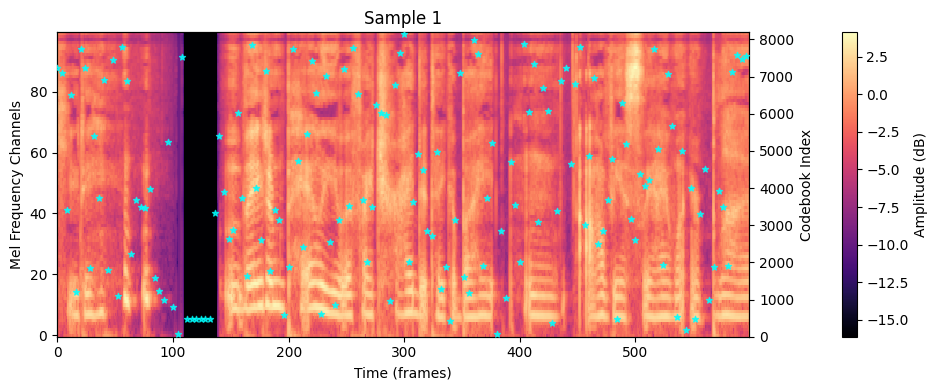

----------------------------------------
Text: Running through the grass, playing under the falling leaves. <laughs> My sweet little kit, the-
Text IDs shape: (28,)
Mel shape: (100, 769)
Codes: (193,)


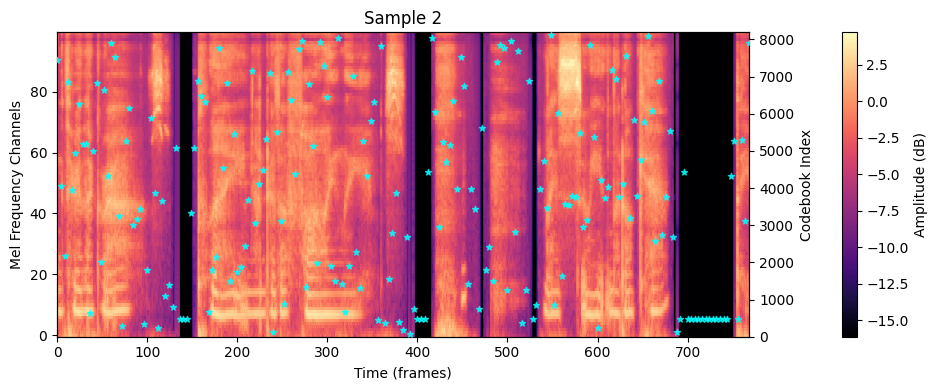

----------------------------------------
Text: Deal with it. I will. I'll just scowl and watch TV by myself <sighs>.
Text IDs shape: (24,)
Mel shape: (100, 938)
Codes: (235,)


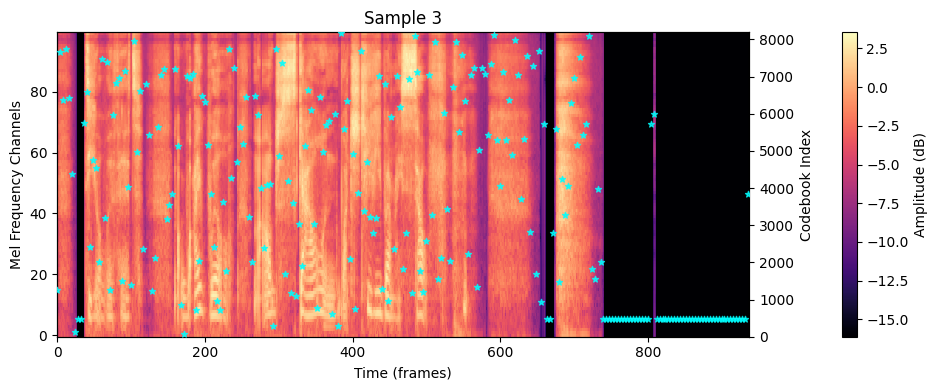

----------------------------------------
Text: I knew you two would get close quickly. Score another one for me! <chuckles> Sheesh!
Text IDs shape: (24,)
Mel shape: (100, 769)
Codes: (193,)


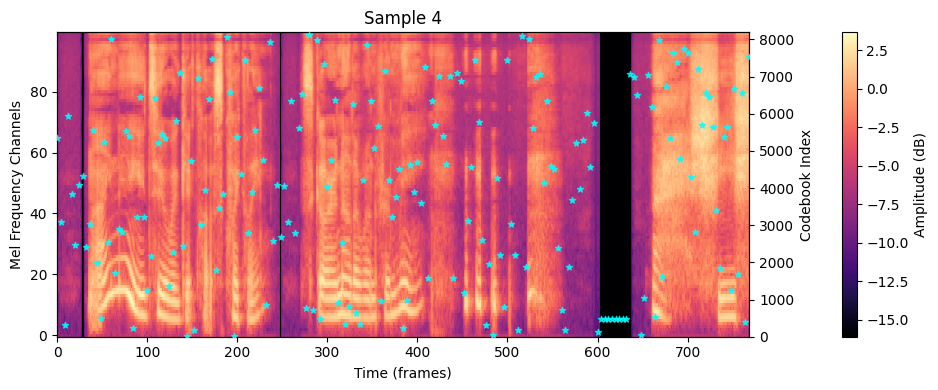

----------------------------------------


In [18]:
#@title show some samples
from IPython.display import display, Audio
from datasets import IterableDataset
import re

ids: IterableDataset = ds.to_iterable_dataset()
supported_tags_pattern = re.compile("|".join([re.escape(tag) for tag in additional_special_tokens]), re.IGNORECASE)
tags_count = {tag: 0 for tag in additional_special_tokens}

def filter_tags(sample, tags_count=tags_count):
    text = sample["text"].upper()
    if m := re.search(supported_tags_pattern, text):
        tag = m.group(0)
        tag = tag.upper()
        tags_count[tag] += 1
        # Limit the number of samples per tag
        return tags_count[tag] <= 1
    return False

random_samples = (
    ids.shuffle(seed=33, buffer_size=10)
    .filter(filter_tags)
    .take(10)
    .with_format("numpy")
    .map(
        process_sample,
        fn_kwargs={"tokenizer": tokenizer},
    )
)

for i, sample in enumerate(random_samples):
    print(f"Text: {sample['text']}")
    print(f"Text IDs shape: {sample['text_ids'].shape}")
    print(f"Mel shape: {sample['mel'].shape}")
    print(f"Codes: {sample['codes'].shape}")
    plot_audio_sample(
        sample["mel"],
        sample["codes"],
        num_codes=config.vqvae.num_tokens,
        title=f"Sample {i + 1}",
    )
    display(Audio(sample["audio"]["array"], rate=sample["audio"]["sampling_rate"].item()))
    print("-" * 40)
del ids, random_samples

In [19]:
# Filter and process the dataset
processed_ds = (
    ds.map(
        pre_process_text,
        fn_kwargs={
            "supported_tags": additional_special_tokens,
            "text_tokenizer": tokenizer.text_tokenizer,
        },
    )
    .filter(lambda sample: tokenizer.text_tokenizer.unk_id() not in sample["text_ids"])
    .map(
        process_sample,
        fn_kwargs={"tokenizer": tokenizer, "shrink_silence": True},
    )
)
print(f"Processed dataset size: {len(processed_ds)}")

Filter:   0%|          | 0/1195 [00:00<?, ? examples/s]

Map:   0%|          | 0/1118 [00:00<?, ? examples/s]

Processed dataset size: 1118


Text: PLEASE HAVE MERCY ON MY DAINTY, FRAIL BODY. YOUR COILS ARE SO STRONG AND POWERFUL, AND I AM POWERLESS TO RESIST.
Text IDs shape: (41,)
Mel shape: (100, 792)
Codes shape: (198,)


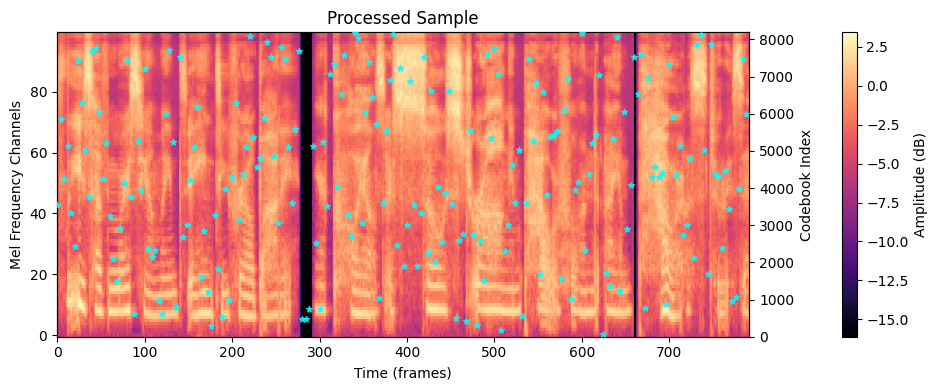

In [20]:
# Show the first processed sample
sample = processed_ds.with_format("numpy")[0]
print(f"Text: {sample['text']}")
print(f"Text IDs shape: {sample['text_ids'].shape}")
print(f"Mel shape: {sample['mel'].shape}")
print(f"Codes shape: {sample['codes'].shape}")
plot_audio_sample(
    sample["mel"],
    sample["codes"],
    num_codes=config.vqvae.num_tokens,
    title="Processed Sample",
)

In [21]:
# save the processed dataset
processed_ds_dir = os.path.join(finetune_model_dir, "processed_dataset")
if not os.path.exists(processed_ds_dir):
    os.makedirs(processed_ds_dir)
print(f"Processed dataset will be saved to: {processed_ds_dir}")
processed_ds.save_to_disk(processed_ds_dir)
print("Processed dataset saved successfully.")

Processed dataset will be saved to: finetune_models\processed_dataset


Saving the dataset (0/2 shards):   0%|          | 0/1118 [00:00<?, ? examples/s]

Processed dataset saved successfully.


### Step5: Expand the text embedding layer of UnifiedVoice model to match the new vocabulary size.

In [22]:
import pandas as pd

number_text_tokens = config.gpt.number_text_tokens
added_num_tokens = len(additional_special_tokens)
new_gpt_config = config.gpt.copy()
new_gpt_config.number_text_tokens = number_text_tokens + added_num_tokens
print("Number of new text tokens added:", added_num_tokens)
print("Original UnifiedVoice model configuration:")
display(pd.DataFrame(list(dict(config.gpt).items()), columns=["Key", "Value"]))

Number of new text tokens added: 4
Original UnifiedVoice model configuration:


,Key,Value
0,model_dim,1280
1,max_mel_tokens,800
2,max_text_tokens,600
3,heads,20
4,use_mel_codes_as_input,True
5,mel_length_compression,1024
6,layers,24
7,number_text_tokens,12000
8,number_mel_codes,8194
9,start_mel_token,8192


Resize the text embeddings and text head of UnifiedVoice model to match the new vocabulary size.

- text_embeddings.weight
- text_head.weight
- text_head.bias

In [23]:
from indextts.gpt.model import UnifiedVoice
import torch.nn.functional as F
from torch.distributions import constraints, multivariate_normal


def init_resized_embeddings_weights_with_mean(old_embedding_weight: torch.Tensor, old_num_tokens, added_num_tokens):
    # follow transformers/modeling_utils.py: _init_added_embeddings_weights_with_mean
    otype = old_embedding_weight.dtype
    reserved_tokens = old_embedding_weight.shape[0] - old_num_tokens
    text_embed_dim = old_embedding_weight.shape[-1]
    assert reserved_tokens >= 0, "The number of old tokens must be greater than or equal to the number of new tokens."
    if reserved_tokens > 0:
        reserved_embedding_weight = old_embedding_weight[old_num_tokens:, :]
        old_embedding_weight = old_embedding_weight[:old_num_tokens, :]
        new_embedding_weight = torch.cat(
            [
                old_embedding_weight,
                torch.zeros((added_num_tokens, text_embed_dim), dtype=otype, device=old_embedding_weight.device),
                reserved_embedding_weight,
            ],
            dim=0,
        )
    else:
        new_embedding_weight = torch.zeros(
            (old_num_tokens + added_num_tokens, text_embed_dim), dtype=otype, device=old_embedding_weight.device
        )
        new_embedding_weight[:old_num_tokens, :] = old_embedding_weight
    old_embed_weight_f32 = old_embedding_weight.to(torch.float32)
    mean_embed = torch.mean(old_embed_weight_f32, axis=0)
    old_centered_embed = old_embed_weight_f32 - mean_embed
    covariance = old_centered_embed.T @ old_centered_embed / old_num_tokens

    epsilon = 1e-9
    is_covariance_psd = constraints.positive_definite.check(epsilon * covariance).all()
    if is_covariance_psd:
        distribution = multivariate_normal.MultivariateNormal(mean_embed, covariance_matrix=epsilon * covariance)
        new_embedding_weight[old_num_tokens : old_num_tokens + added_num_tokens, :] = distribution.sample(
            sample_shape=(added_num_tokens,)
        ).to(otype)
    else:
        new_embedding_weight[old_num_tokens : old_num_tokens + added_num_tokens, :] = (
            mean_embed[None, :].repeat(added_num_tokens, 1).to(otype)
        )
    return new_embedding_weight


def init_added_text_head_bias_with_mean(old_head_bias: torch.Tensor, old_num_tokens, added_num_tokens):
    # follow transformers/modeling_utils.py: _init_added_text_head_bias_with_mean
    old_head_bias = old_head_bias.to(dtype=torch.float32)
    if old_head_bias.shape[0] > old_num_tokens:
        # if the bias has reserved tokens, we need to remove them
        reserved_token_bias = old_head_bias[old_num_tokens:]
        old_head_bias = old_head_bias[:old_num_tokens]
        new_head_bias = torch.zeros(
            (old_num_tokens + added_num_tokens + reserved_token_bias.shape[0]),
            dtype=old_head_bias.dtype,
            device=old_head_bias.device,
        )
        new_head_bias[:old_num_tokens] = old_head_bias
        new_head_bias[old_num_tokens + added_num_tokens :] = reserved_token_bias
    else:
        new_head_bias = torch.zeros(
            (old_num_tokens + added_num_tokens),
            dtype=old_head_bias.dtype,
            device=old_head_bias.device,
        )
        new_head_bias[:old_num_tokens] = old_head_bias
    bias_mean = torch.mean(old_head_bias, axis=0)
    bias_std = torch.std(old_head_bias, axis=0)
    added_bias = torch.zeros(added_num_tokens, dtype=old_head_bias.dtype, device=old_head_bias.device)
    added_bias.normal_(mean=bias_mean, std=1e-9 * bias_std)
    new_head_bias[old_num_tokens : old_num_tokens + added_num_tokens] = added_bias
    return new_head_bias


def resize_text_embedding_weights(state_dict: dict, old_number_text_tokens, added_num_tokens):
    old_text_embedding_weight = state_dict["text_embedding.weight"]
    new_text_embedding_weight = init_resized_embeddings_weights_with_mean(
        old_text_embedding_weight, old_number_text_tokens, added_num_tokens
    )

    # Resize the text head to match the new number of text tokens
    old_text_head_weight = state_dict["text_head.weight"]
    new_text_head_weight = init_resized_embeddings_weights_with_mean(
        old_text_head_weight, old_number_text_tokens, added_num_tokens
    )
    old_text_head_bias = state_dict.get("text_head.bias", None)
    new_state_dict = state_dict.copy()  # shallow copy
    new_state_dict["text_embedding.weight"] = new_text_embedding_weight
    new_state_dict["text_head.weight"] = new_text_head_weight
    if old_text_head_bias is not None:
        new_state_dict["text_head.bias"] = init_added_text_head_bias_with_mean(
            old_text_head_bias, old_number_text_tokens, added_num_tokens
        )
    return new_state_dict


In [24]:
print("Resize text embeddings and text head.")
pre_trained_gpt_path = os.path.join(model_dir, config.gpt_checkpoint)
pre_trained_gpt = torch.load(pre_trained_gpt_path, map_location="cpu", weights_only=True)

resized_text_state_dict = resize_text_embedding_weights(
    pre_trained_gpt["model"] if "model" in pre_trained_gpt else pre_trained_gpt,
    config.gpt.number_text_tokens,
    added_num_tokens,
)

# Save the resized model
finetune_model_dir = "finetune_models"
if not os.path.exists(finetune_model_dir):
    os.makedirs(finetune_model_dir)
resized_model_path = os.path.join(finetune_model_dir, "gpt_resized.pth")
torch.save(resized_text_state_dict, resized_model_path)
new_config = config.copy()
new_config.gpt_checkpoint = os.path.basename(resized_model_path)
new_config.gpt = new_gpt_config
new_config.dataset.bpe_model = os.path.basename(new_bpe_model_path)
new_config.dataset.additional_special_tokens = {
    tag: new_bpe_model.piece_to_id(tag) for tag in additional_special_tokens
}
new_config_path = os.path.join(finetune_model_dir, "config.yaml")
OmegaConf.save(new_config, new_config_path)
print(f"Resized model saved to: {resized_model_path}")
print(f"New configuration saved to: {new_config_path}")

Resize text embeddings and text head.
Resized model saved to: finetune_models\gpt_resized.pth
New configuration saved to: finetune_models\config.yaml


### Copy the other model files to the finetune_models directory

In [25]:

# dvae_checkpoint: dvae.pth
# bigvgan_checkpoint: bigvgan_generator.pth
import shutil

shutil.copy(os.path.join(model_dir, config.dvae_checkpoint), finetune_model_dir)
shutil.copy(os.path.join(model_dir, config.bigvgan_checkpoint), finetune_model_dir)
os.listdir(finetune_model_dir)

['bigvgan_generator.pth',
 'bpe_new.model',
 'checkpoints',
 'config.yaml',
 'dvae.pth',
 'gpt_resized.pth',
 'processed_dataset']

### Next, we will fine-tune the Index-TTS model with the processed dataset.

Open the `fine_tune_indextts.ipynb` notebook to continue.
